# Testing MCTS with Various Models
Here we will test MCTS first with the DKT model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import six
import dynamics_model_class as dmc
import mcts_tests as mc
import mcts
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import dataset_utils
import tensorflow as tf
import tflearn
import time
import copy

from concept_dependency_graph import ConceptDependencyGraph
import data_generator as dg
from student import *
import simple_mdp as sm

In [12]:
n_concepts = 5
use_student2 = True
transition_after = True
student2_str = ('2' if use_student2 else '') + ('a' if use_student2 and transition_after else '')
learn_prob = 0.5
lp_str = '-lp{}'.format(int(learn_prob*100)) if not use_student2 else ''
n_students = 100000
seqlen = 7
filter_mastery = False
filter_str = '' if not filter_mastery else '-filtered'
policy = 'random'
epsilon = 0.3
epsilon_str = '{:.2f}'.format(epsilon) if policy == 'egreedy' else ''
filename = 'test{}-w{}-n{}-l{}{}-{}{}{}.pickle'.format(student2_str, n_concepts, n_students, seqlen,
                                                    lp_str, policy, epsilon_str, filter_str)
#concept_tree = sm.create_custom_dependency()
concept_tree = ConceptDependencyGraph()
concept_tree.init_default_tree(n_concepts)
if not use_student2:
    test_student = Student(n=n_concepts,p_trans_satisfied=learn_prob, p_trans_not_satisfied=0.0, p_get_ex_correct_if_concepts_learned=1.0)
else:
    test_student = Student2(n_concepts, transition_after=transition_after)
six.print_(filename)

test2a-w5-n100000-l7-random.pickle


In [13]:
# Generates the data
# Only run this cell if need to generate new data, otherwise skip this
if False:
    print ("Initializing synthetic data sets...")
    dg.generate_data(concept_tree, student=test_student, n_students=n_students, filter_mastery=filter_mastery, seqlen=seqlen, policy=policy, epsilon=epsilon, filename="{}{}".format(dg.SYN_DATA_DIR, filename))
    print ("Data generation completed. ")

In [14]:
# load toy data
data = dataset_utils.load_data(filename='{}{}'.format(dg.SYN_DATA_DIR, filename))

In [15]:
print('Average posttest: {}'.format(sm.expected_reward(data)))
print('Average sparse reward: {}'.format(sm.expected_sparse_reward(data)))
print('Percent of full posttest score: {}'.format(sm.percent_complete(data)))
print('Percent of all seen: {}'.format(sm.percent_all_seen(data)))
for t in data[0]:
    six.print_(t)

Average posttest: 0.383488
Average sparse reward: 0.0
Percent of full posttest score: 0.0
Percent of all seen: 0.32331
(array([ 1.,  0.,  0.,  0.,  0.]), True, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([ 0.,  0.,  1.,  0.,  0.]), False, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
(array([ 1.,  0.,  0.,  0.,  0.]), True, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0]))
(array([ 0.,  0.,  0.,  0.,  1.]), False, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0]))
(array([ 0.,  0.,  1.,  0.,  0.]), False, array([ 1.,  0.,  1.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0]))
(array([ 0.,  1.,  0.,  0.,  0.]), False, array([ 1.,  0.,  1.,  0.,  0.]), array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0]))
(array([ 0.,  0.,  1.,  0.,  0.]), True, array([ 1.,  0.,  1.,  0.,  0.]), array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0]))


In [28]:
input_data_, output_mask_, target_data_ = dataset_utils.preprocess_data_for_rnn(data)

#six.print_(input_data_.shape)
#six.print_(output_mask_.shape)
#six.print_(target_data_.shape)
#six.print_(processed_input_data[0,:,:])
#six.print_(output_mask_[0,:,:])
#six.print_(target_data_[0,:,:])

(100000, 6, 10)
(100000, 6, 5)
(100000, 6, 5)
[[ 1.0075767   0.0085181   0.05095376  0.07627983  0.02619065  0.02820413
  -0.05865049 -0.0136155   0.03133349 -0.06642795]
 [-0.02580618  0.06678505 -0.07659421 -0.01400643 -0.02811988  0.06143501
   0.03311314  1.06634151  0.04335824  0.00245075]
 [ 1.05773841  0.02777701 -0.03732225  0.08330457  0.02192283  0.03916011
   0.03391227  0.03879349 -0.02651187  0.05641536]
 [ 0.09809475 -0.04334863 -0.06716578  0.0434546   0.02426757 -0.01200596
   0.03804937 -0.06962593  0.11690845  0.95632   ]
 [-0.04992575  0.05142208 -0.11706015 -0.05186272 -0.04626833  0.04721583
   0.15299859  1.04981163 -0.05391425  0.0355845 ]
 [-0.09760005 -0.04158942  0.00580815  0.08399279 -0.03875535  0.04413252
   0.95509472  0.06533436  0.04776776 -0.00597414]]
[[ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 

In [55]:
# test_model hidden=16
# test_model_mid hidden=10
# test_model_small hidden=5
# test_model_tiny hidden=3
model_id = "test2w5_modelgrusimple_mid"
dmodel = dmc.DynamicsModel(model_id=model_id, timesteps=seqlen-1, dropout=1.0, load_checkpoint=False)

Loading RNN dynamics model...
Directory path for tensorboard summaries: ../tensorboard_logs/test2w5_modelgrusimple_mid/
Checkpoint directory path: ../checkpoints/test2w5_modelgrusimple_mid/
Model loaded.


In [52]:
# extract out the training states
class ExtractCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.tstates = []
    def on_epoch_begin(self,ts):
        self.tstates.append([])
    def on_batch_end(self,ts,snapshot):
        self.tstates[-1].append(copy.copy(ts))
ecall = ExtractCallback()

In [53]:
num_epoch_batch = 100
num_epoch_per_batch = 1
for eb in six.moves.range(num_epoch_batch):
    # add noise to each batch
    processed_input_data = input_data_ + 0.01*np.random.randn(*input_data_.shape)
    train_data = (processed_input_data[:,:,:], output_mask_[:,:,:], target_data_[:,:,:])
    dmodel.train(train_data,
                 n_epoch=num_epoch_per_batch,
                 callbacks=ecall,
                 load_checkpoint=False,
                 shuffle=True,
                 validation_set=0.1,
                batch_size=1024)

Training Step: 8799  | total loss: 0.00037 | time: 1.182s
| Adam | epoch: 100 | loss: 0.00037 -- iter: 89088/90000
Training Step: 8800  | total loss: 0.00034 | time: 2.199s
| Adam | epoch: 100 | loss: 0.00034 | val_loss: 0.00016 -- iter: 90000/90000
--
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'


Train Loss Limit: 0.00036902
Val Loss Limit: 0.00015864 Thresh: 0.00016864


(0, 0.0003)

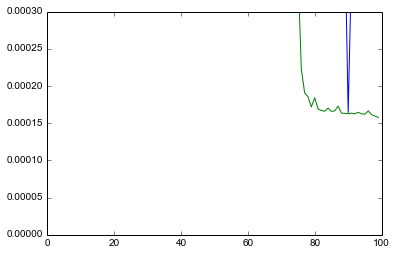

In [54]:
# binary crossentropy doesn't work
# default batch size of 64 with 100000 trajectories is 1562.5 iters per epoch
# which means 40 epochs is 62,500 iters
train_loss = np.array([np.mean([ts.global_loss for ts in batch]) for batch in ecall.tstates])
val_loss = np.array([batch[-1].val_loss for batch in ecall.tstates])
figure()
plot(train_loss)
plot(val_loss)
last_val_loss = np.mean(val_loss[-2:])
val_loss_thres = last_val_loss + 0.00001
last_train_loss = np.mean(train_loss[-2:])
#xlim(40,50)
six.print_('Train Loss Limit: {:.8f}'.format(last_train_loss))
six.print_('Val Loss Limit: {:.8f} Thresh: {:.8f}'.format(last_val_loss, val_loss_thres))
#plot([0,train_loss.shape[0]], [last_val_loss,last_val_loss], color='#ff0000')
#plot([0,train_loss.shape[0]], [val_loss_thres,val_loss_thres], color='#ff0000')
#ylim(last_val_loss - 0.00001, last_val_loss + 0.00002)
ylim(0,0.0003)
# training length 7
# trying gru simple mid size with learning rate 0.01: seems like about <40 epochs is good enough
# gru simple small size with lr 0.01: looks like 34 is enough
# simple mid size of lr 0.01: looks like 34 is enough
# simple small size of lr 0.01: looks like 34 is enough
# try it out dropout=0.8
# gru simple mid size lr 0.01: doesn't seem like 70 eps is enough, though after 40 it seems stable, val loss seems to converge much earlier
# simple mid size lr 0.01: doesn't seem like 60 is enough, kinda stable-ish? after 30 epochs, validation loss also seems mostly stable
# overall it seems like 40 epochs is enough for everything, small, mid, or dropout
# training length 6
# looks like 50 epochs is needed to stablize

In [28]:
# predict a bit
dataix = 4
test_input_data = input_data_[dataix:dataix+1,:,:]
six.print_(test_input_data)
six.print_(data[dataix][-1])
prediction = dmodel.predict(test_input_data)
six.print_(prediction)
# add one observation of each type and see what the predictions are
for nexta in six.moves.range(n_concepts*2):
    obvec = np.zeros((n_concepts*2,))
    obvec[nexta] = 1.0
    #six.print_(test_input_data[0,:,:].shape)
    #six.print_(obvec[np.newaxis,:].shape)
    test_input_data2 = np.vstack((test_input_data[0,:,:],obvec[np.newaxis,:]))
    six.print_('Next observation: {}'.format(obvec))
    prediction = dmodel.predict(test_input_data2[np.newaxis,:,:])
    six.print_('Next prediction: ' + ' '.join('{:.4f}'.format(x) for x in prediction[0,seqlen-2,:]))

[[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]
(array([0, 0, 1, 0, 0]), False, array([ 1.,  0.,  1.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0]))
[[[  9.89955425e-01   9.93815903e-03   3.90697550e-03   1.11842304e-02
     1.21492986e-02]
  [  9.96909678e-01   2.56332522e-03   1.31003105e-03   3.43835377e-03
     3.67564568e-03]
  [  9.96933818e-01   7.99560396e-04   2.66281962e-02   3.14442441e-03
     3.22895916e-03]
  [  9.97086704e-01   8.41905188e-04   2.04637181e-02   2.99884751e-03
     3.09865386e-03]
  [  9.97224927e-01   8.79694184e-04   1.60780381e-02   2.86530796e-03
     2.97611044e-03]
  [  9.97369528e-01   9.46325716e-04   1.11178551e-02   2.72916351e-03
     2.85732327e-03]]]
Next observation: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Next prediction

In [29]:
# save the model to a checkpoint file
chkpt = 'tempmodel'
dmodel.save(chkpt)

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'


In [ ]:
# test the model on the real environment
test_horizon = 8
n_rollouts = 3000
n_trajectories = 8
r_type = mcts.SPARSE

test_student = Student2(n_concepts, transition_after=transition_after)
test_student.reset()
test_student.knowledge[0] = 1 # initialize the first concept to be known
sim = StudentExactSim(test_student.copy(), concept_tree)

starttime = time.time()
mc.test_dkt_chunk(n_trajectories, concept_tree, sim, model_id, chkpt, test_horizon, n_rollouts, r_type)
#mc.test_dkt(model_id, n_concepts, transition_after, test_horizon, n_rollouts, n_trajectories, r_type, True, chkpt=chkpt)
endtime = time.time()
six.print_('Time Elapsed {}'.format(endtime - starttime))

Testing model: test2w5_modelgrusimple_mid
horizon: 8
rollouts: 3000
Loading RNN dynamics model...
Loading RNN dynamics model...
Loading RNN dynamics model...
Loading RNN dynamics model...
Loading RNN dynamics model...
Loading RNN dynamics model...
Loading RNN dynamics model...
Loading RNN dynamics model...
Directory path for tensorboard summaries: ../tensorboard_logs/test2w5_modelgrusimple_mid/
Directory path for tensorboard summaries: ../tensorboard_logs/test2w5_modelgrusimple_mid/
Checkpoint directory path: ../checkpoints/test2w5_modelgrusimple_mid/
Checkpoint directory path: ../checkpoints/test2w5_modelgrusimple_mid/
Directory path for tensorboard summaries: ../tensorboard_logs/test2w5_modelgrusimple_mid/
Checkpoint directory path: ../checkpoints/test2w5_modelgrusimple_mid/
Directory path for tensorboard summaries: ../tensorboard_logs/test2w5_modelgrusimple_mid/
Checkpoint directory path: ../checkpoints/test2w5_modelgrusimple_mid/
Directory path for tensorboard summaries: ../tensorb